<a href="https://colab.research.google.com/github/leburik-1/Django-rest-framework-API-watchmate-/blob/main/Titanic%20Dataset%20and%20the%20Scikit-%20Learn%20DecisionTreeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install --upgrade dtreeviz

In [5]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report)

import graphviz
import dtreeviz
from sklearn.inspection import PartialDependenceDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

plt.style.use("ggplot")
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'DejaVu Sans'

In [15]:
from plotly.subplots import make_subplots

In [34]:
!pip install phik

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 8.8 MB/s eta 0:00:00


In [19]:
import plotly.graph_objects as go

In [35]:
import phik
from phik import resources

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
pd.set_option('display.max_columns',20)

In [8]:
# Load dataset
file_path = '/content/drive/My Drive/ml_data/Titanic Dataset.csv'
df = pd.read_csv(file_path, index_col=0)


# print(f"\n\033[1mData Dimensions:\033[0m {df.shape}")
print(f"\n\033[1mDataset Shape: \033[0m\n {df.shape}")
print(f"\n\033[1mDescribe data\n: \033[0m\n{df.describe()}")
print(f"\n\033[1mColumns: \033[0m\n {df.columns}")


Dataset Shape: 
 (1309, 13)

Describe data
: 
          survived          age        sibsp        parch         fare  \
count  1309.000000  1046.000000  1309.000000  1309.000000  1308.000000   
mean      0.381971    29.881138     0.498854     0.385027    33.295479   
std       0.486055    14.413493     1.041658     0.865560    51.758668   
min       0.000000     0.170000     0.000000     0.000000     0.000000   
25%       0.000000    21.000000     0.000000     0.000000     7.895800   
50%       0.000000    28.000000     0.000000     0.000000    14.454200   
75%       1.000000    39.000000     1.000000     0.000000    31.275000   
max       1.000000    80.000000     8.000000     9.000000   512.329200   

             body  
count  121.000000  
mean   160.809917  
std     97.696922  
min      1.000000  
25%     72.000000  
50%    155.000000  
75%    256.000000  
max    328.000000  

Columns: 
 Index(['survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', '

In [9]:
print("\n\033[1mMissing Values: \033[0m\n")
display(df.isna().sum().to_frame('Missing Values').style.background_gradient(cmap='Reds'))


Missing Values: 



,Missing Values
survived,0
name,0
sex,0
age,263
sibsp,0
parch,0
ticket,0
fare,1
cabin,1014
embarked,2


In [10]:
def statistical_profile(data):
  stats_df = pd.DataFrame(index=data.columns)
  stats_df['Data Type'] = data.dtypes
  stats_df['Missing %'] = (data.isnull().mean()*100).round(2)
  stats_df['Unique Values'] = data.nunique()
  stats_df['Skewness'] = data.skew(numeric_only=True).round(2)
  stats_df['kurtosis'] = data.kurtosis(numeric_only=True).round(2)

  desc = data.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T
  stats_df = stats_df.join(desc)

  return stats_df

print("\n\033[1mAdvanced Statistical Profile:\033[0m")
display(statistical_profile(df).style.background_gradient(cmap='Blues', subset=['Missing %', 'Skewness', 'kurtosis']))


Advanced Statistical Profile:


,Data Type,Missing %,Unique Values,Skewness,kurtosis,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
survived,int64,0.000000,2,0.490000,-1.770000,1309.000000,0.381971,0.486055,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
name,object,0.000000,1307,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sex,object,0.000000,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
age,float64,20.090000,98,0.410000,0.150000,1046.000000,29.881138,14.413493,0.170000,0.920000,5.000000,21.000000,28.000000,39.000000,57.000000,65.000000,80.000000
sibsp,int64,0.000000,7,3.840000,20.040000,1309.000000,0.498854,1.041658,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,5.000000,8.000000
parch,int64,0.000000,8,3.670000,21.540000,1309.000000,0.385027,0.865560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,9.000000
ticket,object,0.000000,929,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
fare,float64,0.080000,281,4.370000,27.030000,1308.000000,33.295479,51.758668,0.000000,0.000000,7.225000,7.895800,14.454200,31.275000,133.650000,262.375000,512.329200
cabin,object,77.460000,186,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
embarked,object,0.150000,3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [11]:

# Missing Data imputation using MICE
def mice_imputation(data, target_var='survived'):
  numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()

  if target_var in numeric_features:
    numeric_features.remove(target_var)

    # Initialize MICE imputer
    imputer = IterativeImputer(max_iter=10, random_state=42)
    data_imputed = data.copy()
    data_imputed[numeric_features] = imputer.fit_transform(data[numeric_features])

    return data_imputed


df_imputed = mice_imputation(df)
print("\n\033[1mMissing Values After MICE Imputation:\033[0m")

display(df_imputed.isna().sum().to_frame('Missing Values').style.background_gradient(cmap='Greens'))




Missing Values After MICE Imputation:


,Missing Values
survived,0
name,0
sex,0
age,0
sibsp,0
parch,0
ticket,0
fare,0
cabin,1014
embarked,2


In [12]:
def feature_engineering(data):
  df = data.copy()

  # Extract title from name
  df['title'] = df['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
  df['title'] = df['title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr','Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
  df['title'] = df['title'].replace('Mlle', 'Miss')
  df['title'] = df['title'].replace('Ms', 'Miss')
  df['title'] = df['title'].replace('Mme', 'Mrs')

  # Family Features
  df['family_size'] = df['sibsp'] + df['parch'] + 1
  df['is_alone'] = (df['family_size'] == 1).astype(int)

  # Cabin Features
  df['cabin_known'] = (~df['cabin'].isna()).astype(int)
  df['cabin_class'] = df['cabin'].str[0]

  # Fare Features
  df['fare_per_person'] = df['fare'] / df['family_size']
  df['fare_category'] = pd.qcut(df['fare'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

  # Age Features
  df['age_category'] = pd.cut(df['age'], bins=[0,12,18,35,60,100], labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])
  return df


In [13]:
df_engineered = feature_engineering(df_imputed)
df_engineered

# df_engineered = advanced_feature_engineering(df_imputed)

,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,...,body,home.dest,title,family_size,is_alone,cabin_known,cabin_class,fare_per_person,fare_category,age_category
pclass,,,,,,,,,,,,,,,,,,,,,
1,1,"Allen, Miss. Elisabeth Walton",female,29.000000,0.0,0.0,24160,211.3375,B5,S,...,160.677042,"St Louis, MO",Miss,1.0,1,1,B,211.3375,Very High,Young Adult
1,1,"Allison, Master. Hudson Trevor",male,0.920000,1.0,2.0,113781,151.5500,C22 C26,S,...,160.710038,"Montreal, PQ / Chesterville, ON",Master,4.0,0,1,C,37.8875,Very High,Child
1,0,"Allison, Miss. Helen Loraine",female,2.000000,1.0,2.0,113781,151.5500,C22 C26,S,...,160.710440,"Montreal, PQ / Chesterville, ON",Miss,4.0,0,1,C,37.8875,Very High,Child
1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.000000,1.0,2.0,113781,151.5500,C22 C26,S,...,135.000000,"Montreal, PQ / Chesterville, ON",Mr,4.0,0,1,C,37.8875,Very High,Young Adult
1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.000000,1.0,2.0,113781,151.5500,C22 C26,S,...,160.719004,"Montreal, PQ / Chesterville, ON",Mrs,4.0,0,1,C,37.8875,Very High,Young Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,0,"Zabour, Miss. Hileni",female,14.500000,1.0,0.0,2665,14.4542,NaN,C,...,328.000000,NaN,Miss,2.0,0,0,NaN,7.2271,Medium,Teen
3,0,"Zabour, Miss. Thamine",female,27.585274,1.0,0.0,2665,14.4542,NaN,C,...,160.819564,NaN,Miss,2.0,0,0,NaN,7.2271,Medium,Young Adult
3,0,"Zakarian, Mr. Mapriededer",male,26.500000,0.0,0.0,2656,7.2250,NaN,C,...,304.000000,NaN,Mr,1.0,1,0,NaN,7.2250,Low,Young Adult



Feature Correlation Matrix (Phik):
Index(['survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', 'embarked', 'boat', 'body', 'home.dest', 'title',
       'family_size', 'is_alone', 'cabin_known', 'cabin_class',
       'fare_per_person', 'fare_category', 'age_category'],
      dtype='object')
interval columns not set, guessing: ['survived', 'age', 'fare', 'family_size', 'cabin_known']


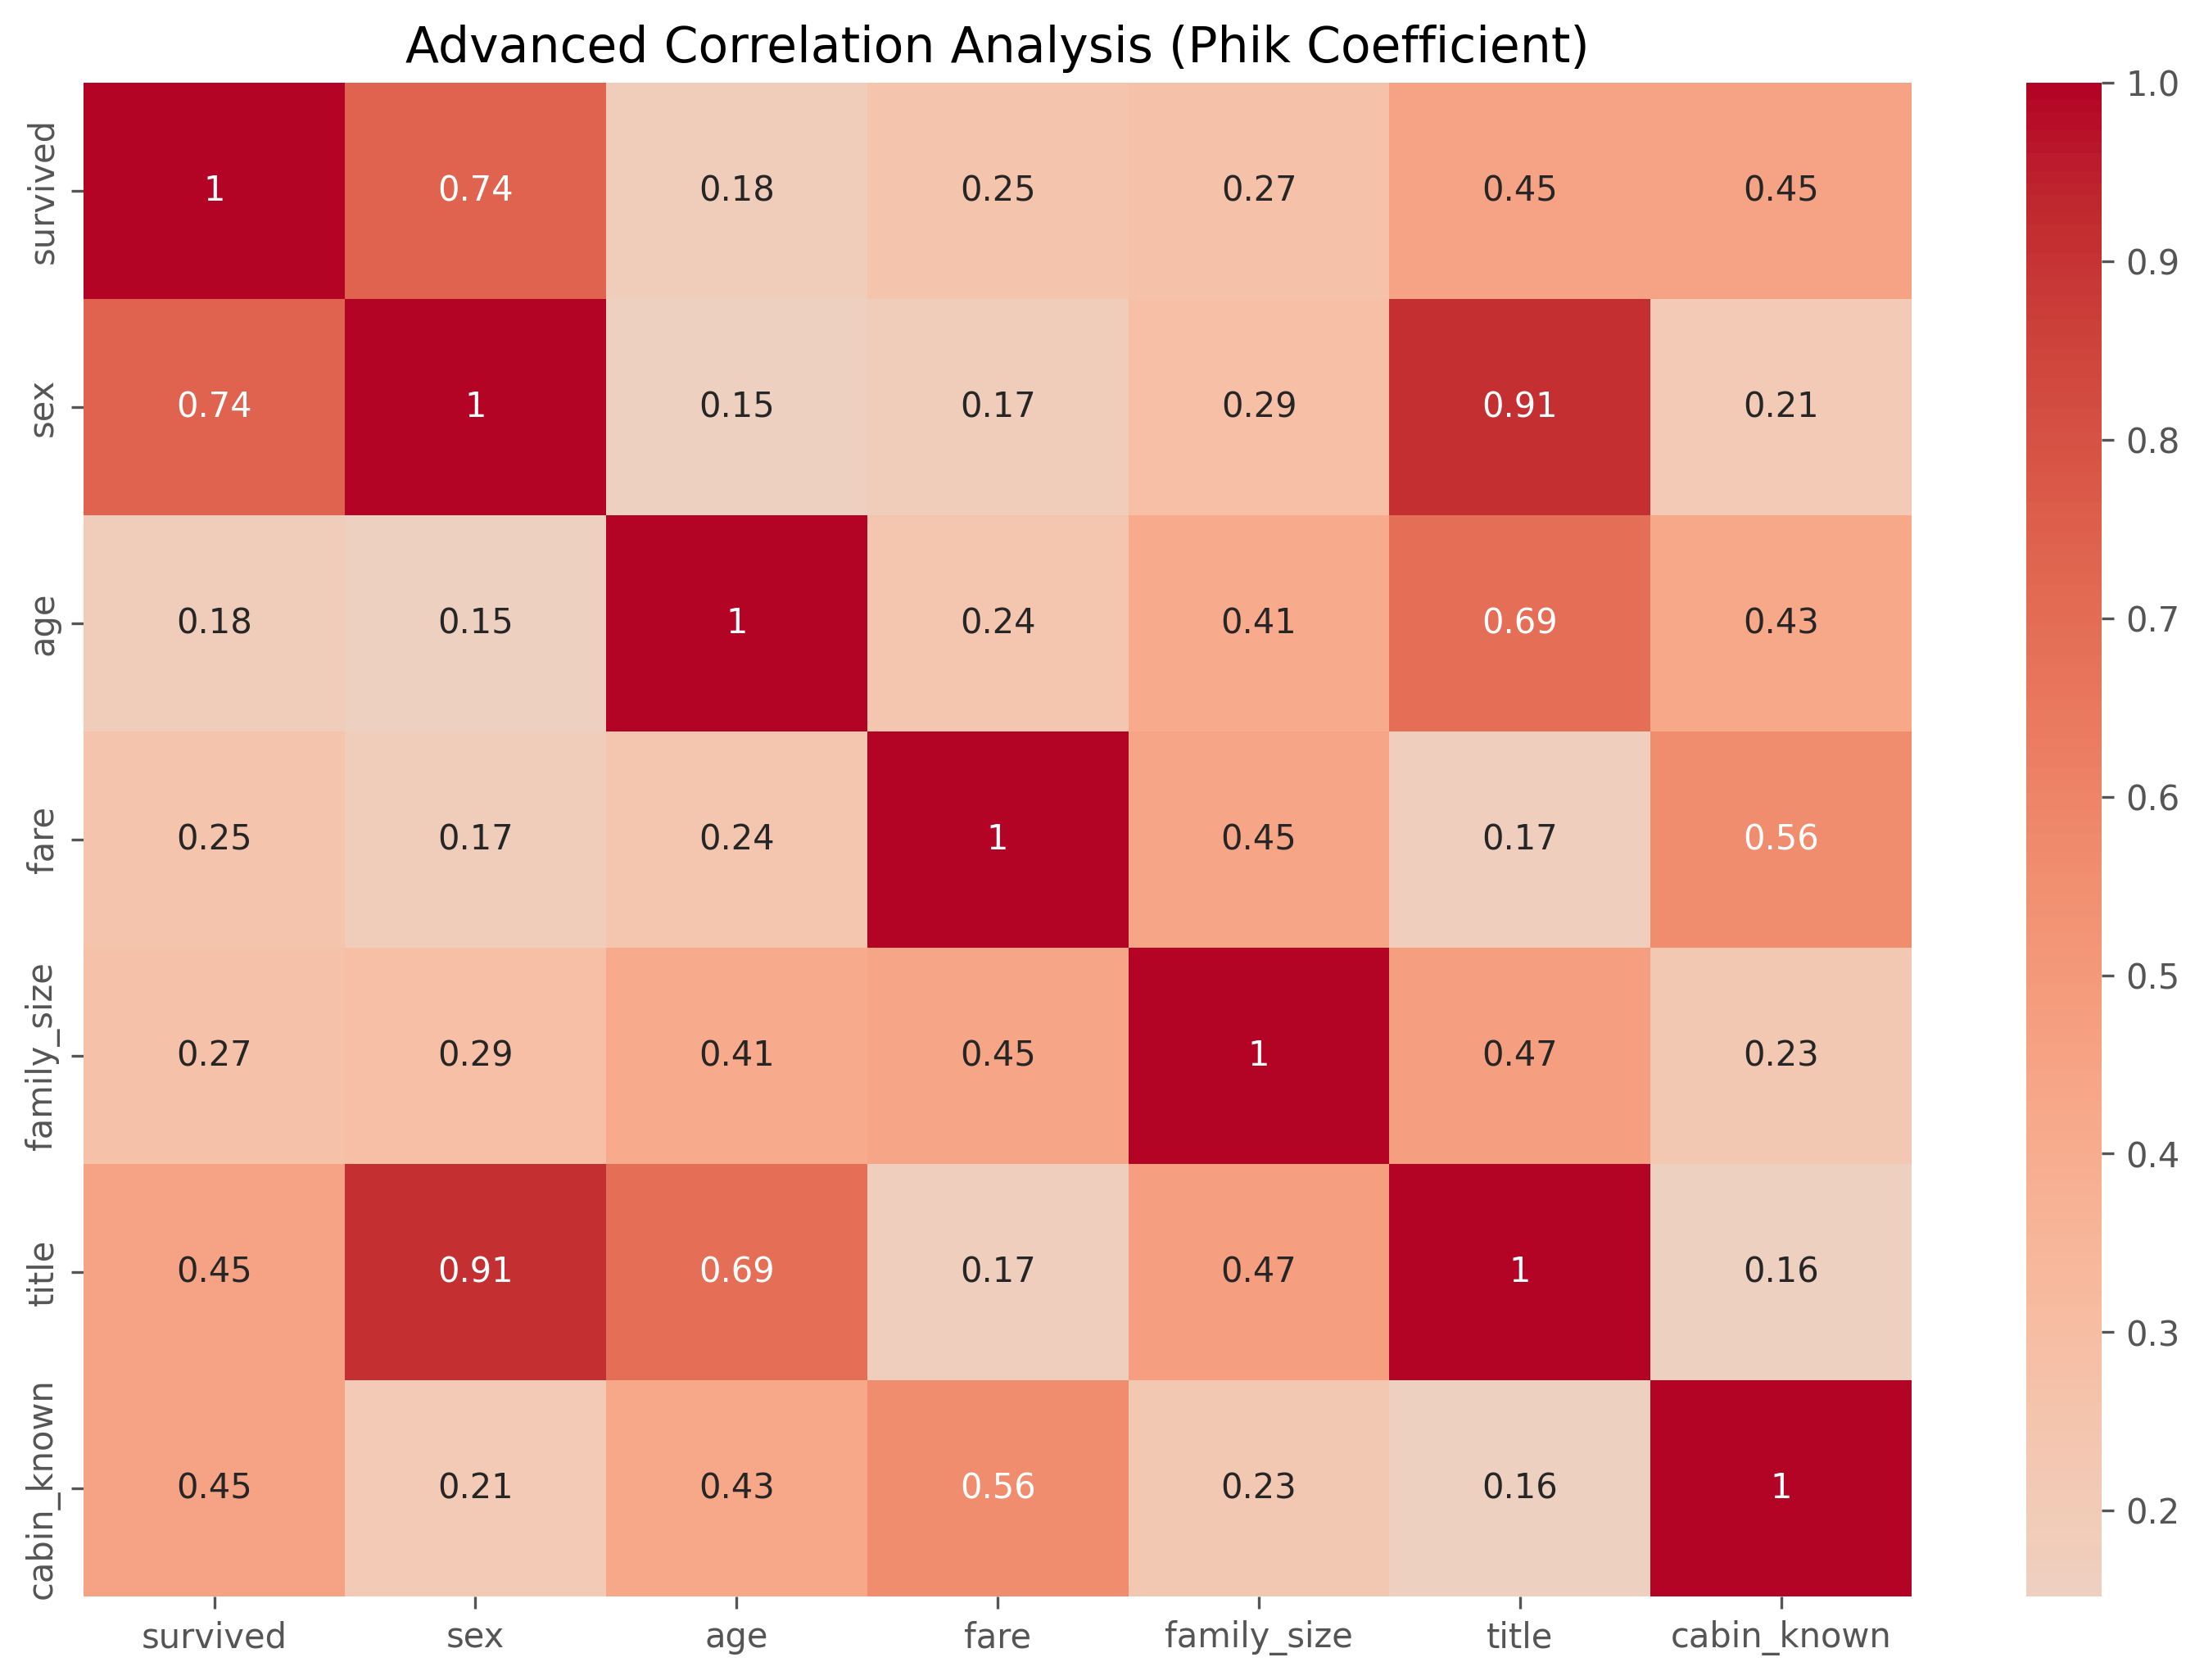

In [37]:
def visualizations_advanced(data):
  # Survival rate by multiple dimensions
  fig = make_subplots(rows=2, cols=2,
                      specs=[
        [{'type': 'xy'}, {'type': 'xy'}],
        [{'type': 'xy'}, {'type': 'xy'}]
    ],

                      subplot_titles = ("Survival by Sex and Class",
                                        "Survival by Age and Fare",
                                        "Survival by Family Size",
                                        "Survival by Title"))

  # Plot1: Survival by Sex and Class
  sex_class_1 = data.groupby(['sex', 'pclass'])['survived'].mean()

  sex_class_df = sex_class_1.reset_index(name='survival_rate')
  sex_class = sex_class_df.pivot(index='sex', columns='pclass', values='survival_rate')

  # print(sex_class.head())
  fig.add_trace(go.Bar(x=sex_class.index, y=sex_class[1], name='1st Class'), row=1, col=1)
  fig.add_trace(go.Bar(x=sex_class.index, y=sex_class[2], name='2nd Class'), row=1, col=1)
  fig.add_trace(go.Bar(x=sex_class.index, y=sex_class[3], name='3rd Class'), row=1, col=1)

  #Plot2: Survival by Age and Fare
  fig.add_trace(go.Scatter(x=data['age'], y=data['fare'],
                           mode='markers',
                           marker=dict(color=data['survived'],
                                       colorscale='Viridis',
                                       showscale=True),
                           name='Age vs Fare'), row=1, col=2)


#Plot 3: Survival by Family Size
  family_survival = data.groupby('family_size')['survived'].mean()
  fig.add_trace(go.Bar(x=family_survival.index, y=family_survival.values,
                       name='Family Size Survival'), row=2, col=1)

# Plot 4: Survival by Title
  title_survival = data.groupby('title')['survived'].mean().sort_values()
  fig.add_trace(go.Bar(x=title_survival.index, y=title_survival.values,
                       name='Title Survival'), row=2,col=2)

  fig.update_layout(height=800, width=1000, title_text="Advanced Survival Analysis", showlegend=False)
  fig.show()

# Correlation analysis with Phik
  print("\n\033[1mFeature Correlation Matrix (Phik):\033[0m")
  cols = ['survived', 'sex', 'age', 'fare', 'family_size', 'title', 'cabin_known']
  print(data.columns)
  phik_matrix = data[cols].phik_matrix()
  plt.figure(figsize=(12,8))
  sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', center=0)
  plt.title("Advanced Correlation Analysis (Phik Coefficient)")
  # fig.update_traces(contours_coloring="fill", contours_showlabels=True)
  fig.update_traces(marker=dict(color='blue', opacity=0.6), showlegend=True)
  fig.show()


visualizations_advanced(df_engineered)


#  # Correlation analysis with Phik
#     print("\n\033[1mFeature Correlation Matrix (Phik):\033[0m")
#     cols = ['survived', 'pclass', 'sex', 'age', 'fare', 'family_size', 'title', 'cabin_known']
#     phik_matrix = df_engineered[cols].phik_matrix()
#     plt.figure(figsize=(12,8))
#     sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', center=0)
#     plt.title("Advanced Correlation Analysis (Phik Coefficient)")
#     plt.show()

#     # Interactive survival probability by age and fare
#     fig = px.density_contour(df_engineered, x='age', y='fare', color='survived',
#                             category_orders={'survived': [0, 1]},
#                             labels={'survived': 'Survived'},
#                             title="Survival Probability by Age and Fare")
#     fig.update_traces(contours_coloring="fill", contours_showlabels=True)
#     fig.show()

# advanced_visualizations(df_engineered)

# # Plot 2: Survival by Age and Fare
#     fig.add_trace(go.Scatter(x=data['age'], y=data['fare'],
#                             mode='markers',
#                             marker=dict(color=data['survived'],
#                                        colorscale='Viridis',
#                                        showscale=True),
#                             name='Age vs Fare'), row=1, col=2)

  # # Plot 1: Survival by Sex and Class
  #   sex_class = data.groupby(['sex', 'pclass'])['survived'].mean().unstack()
  #   fig.add_trace(go.Bar(x=sex_class.index, y=sex_class[1], name='1st Class'), row=1, col=1)
  #   fig.add_trace(go.Bar(x=sex_class.index, y=sex_class[2], name='2nd Class'), row=1, col=1)
  #   fig.add_trace(go.Bar(x=sex_class.index, y=sex_class[3], name='3rd Class'), row=1, col=1)